<a href="https://colab.research.google.com/github/iamasafree/pyupdatermywx/blob/master/FatTails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Толстые хвосты и их влияние на ценообразование опционов**
#### Куртозис, определяющий толщину хвостов и контр-интуитивные результаты тестов
Марк Джеймисон

Торговля опционами обычно ассоциируется со словами "выпуклость"и "плечо", базируясь на предположении, то опционы - это наилучший инструмент для того, чтобы заработать на значительных движениях цены базового актива, независимо от направления этих движений.

Данное мнение распространилось за счет демонстрации этой особенности опционов в популярных кинофильмах типа "Игра на понижение", а также за счет тех событий, которые в январе 2021 года произошли вокруг WallStreetBets и их интереса к GameStop.

Хотя опционы действительно позволяют получить большее плечо, утверждение, что любые опционы позволят выиграть вследствие значительных движений цены базового актива, не совсем верно. Цель данного блокнота уточнить данное утверждение, определив:
*    какие именно движения (математически) мы будем считать значительными
*    диапазон распределений, который покажет непостоянную склонность ценового процесса выдавать значительные движения
*    как эти распределения повлияют на ценообразование опционов

### Толстые хвосты

"Значительными" ценовые движения могут быть только относительно чего-то, в сравнении с чем-то. Среднее суточное движение того или иного базового актива может быть значительным для другого актива, если он менее волатилен.

Ценовые движения обычно называют "приращениями", а точнее "лог-приращениями", поэтому их мы и станем моделировать, сгенерив некоторый ценовой ряд и построив гистограмму распределения. Таким образом, мы покажем, что можно считать "средним движением" - то движение, которое встречается в большей части случаев, и, исходя из этого, выясним, какое движение определять как значительное.

Для иллюстрации возьмем ряд суточных приращений SPX.


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

[*********************100%***********************]  1 of 1 completed


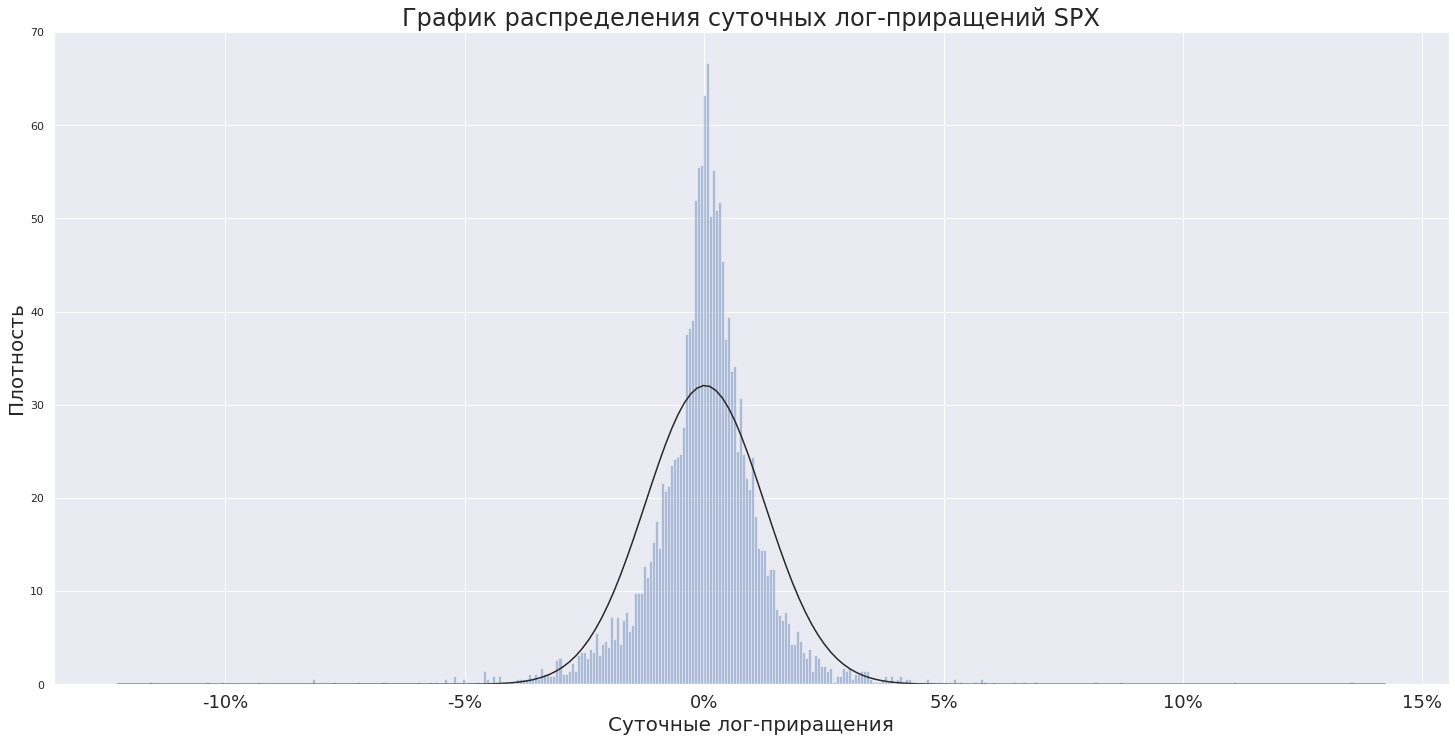

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings
import yfinance as yf

from scipy.integrate import simps
from scipy.interpolate import interp1d

warnings.filterwarnings('ignore')
sns.set()

# подготовка данных
df = yf.download('SPY', start='2000-11-27', end='2022-11-27')
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df['ret'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna()
df.head()

# отрисовка
fig, ax = plt.subplots(ncols=1, figsize=(25,12))
sns.distplot(df['ret'], kde=False, fit=stats.norm, ax=ax, bins=400)
# метки
ax.set_title("График распределения суточных лог-приращений SPX", fontsize=24)
ax.set_xlabel("Суточные лог-приращения", fontsize=20)
ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()], fontsize=18)
ax.set_ylabel("Плотность", fontsize=20);

Как видно, большинство суточных движений цены находится в диапазоне плюс-минус 2%, совсем мало приращений превышают плюс-минус 4-5%, а распределение в целом имет форму колокола. Однако мы нанесли на график функцию плотности нормального распределения (черным цветом) и можем отметить, что полученное распределение далеко от нормального: маленьких приращений существенно больше, чем должно быть при нормальном распределении, а "хвосты" толще, чем оно предполагает (значительных ценовых движений происходит больше).

Другими словами, как бы мы ни задали распределение (через дисперсию или через среднее абсолютное отклонение), "значительные" ценовые движения будут его "хвостами".

### Где же начинаются эти самые хвосты?

Если рассмотреть колоколообразные графики функций плотности, легко понятно, что хвосты, это тонкие части графика слева и справа, и чем дальше мы будем смотреть от центра, тем ближе к 0 будет плотность на хвостах. Кончается хвост в точке, где плотность 0. А вот где начинается? Теоретически этот вопрос решить не так-то просто. Он начинается после трех стандартных отклонений? Или после двух с половиной? Или после четырех? Или место, где он начинается, не связано со стандартным отклонением никак?

Нет единого мнения, относительно того, где у распределения начинаются хвосты, но нам все-таки придется использовать какой-то подход, и возьмем мы подход Нассима Талеба из технической части к его Пятикнижию (Одураченные случайностью, Черный лебедь и т.д.)

### Определение

"Хвост распределения начинается в точке, где функция плотности вероятности становится выпуклой по отношению к колебаниям дисперсии".

Проще говоря: вместо того, чтобы брать, к примеру, нормальное распределение с фиксированными матожиданием и дисперсией, мы возьмем среднее двух нормальных распределений с разной дисперсией. Так мы добьемся стохастичности дисперсии, но только для двух состояний - высокая и низкая.

Чтобы это сделать:
*    рассчитаем функцию плотности нормального распределения с дисперсией 1-e
*    рассчитаем функцию плотносит нормального распределения с дисперсией 1+e
*    возьмем от них среднее
*    повторим эти три шага для разных значений e

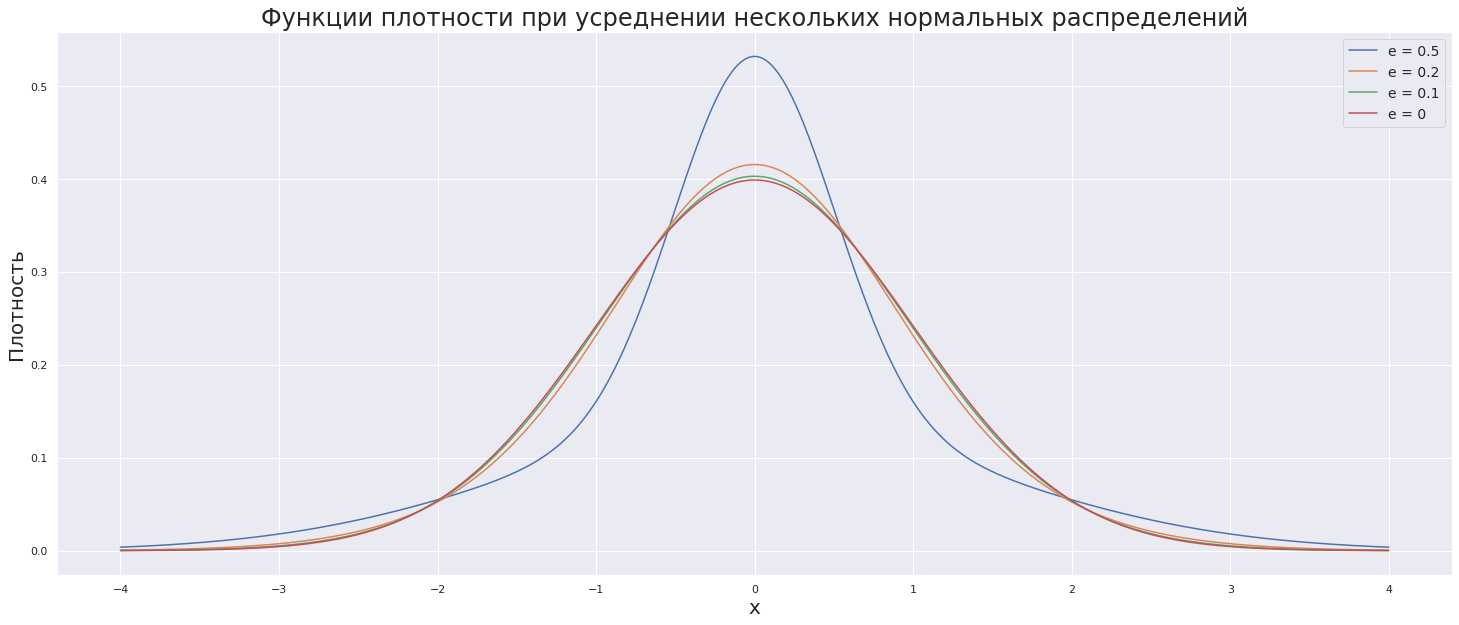

In [ ]:
# функция плотности нормального распределения
def norm_pdf(x, sigma=1):
    return (1 / np.sqrt(2*np.pi)) * (1 / sigma) * np.exp(-0.5 * (x/sigma)**2)

# значения случайной величины
xs = np.linspace(-4, 4, 8*200 + 1)
# эпсилоны
eps = [0, 0.1, 0.2, 0.5]
# создаем функции плотности
perturbs = []
for e in eps[::-1]:
    p = [0.5 * (norm_pdf(x, 1 + e) + norm_pdf(x, 1 - e)) for x in xs]
    perturbs.append([xs, p])

# отрисовываем
fig, ax = plt.subplots(figsize=(25,10))

for dist, e in zip(perturbs, eps[::-1]):
    ax.plot(dist[0], dist[1], label="e = {}".format(e))

ax.set_title("Функции плотности при усреднении нескольких нормальных распределений", fontsize=24)
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("Плотность", fontsize=20)
ax.legend(fontsize=14);

Перед нами графики функций плотности, полученные с разными значениями e. Если e = 0, распределение не отличается от нормального. И что мы видим?
*    все графики функций имеют, как и ожидалось, форму колокола
*    по мере увеличения значения e, увеличивается и пик в центре
*    по мере увеличения значения e, увеличивается значение плотности на хвостах.

Но самое важное: **все распределения пересекаются в одних и тех же точках**. Это точки +/-0.66 стандартных отклонений и +/- 2.13 стандартных отклонений, их-то мы и используем для определения хвостов. Теперь можно выделить следующие компоненты распределения:
*    "хвосты" - области, удаленные на +/-2.13 стандартных отклонений от центра, значение плотности вероятностей на которых увеличивается при стохастичной волатильности
*    "плечи" - области между -2.13 СКО и -0.66 СКО (левое) и 0.66 СКО и 2.13 СКО (правое), значение плотности вероятностей на которых уменьшается при стохастической волатильности
*    "пик / тело" - область между -0.66 СКО и +0.66 СКО, где плотность вероятностей тоже увеличивается при стохастичной волатильности

Другими словами, **если утолщаются хвосты распределения, увеличивается количество мелких ценовых движений и уменьшается количество приращений среднего размера**. Возвращаясь к авторскому определению, хвосты  выпуклы по отношению к стохастичной волатильности, потому что по мере добавления колебаний волатильности, плотность вероятностей там скорее вырастет, чем уменьшится.

### Как все это бьется с разговорами о куртозисе и толстых хвостах?

Куртозис - четвертый момент распределения. Его так же можно рассматривать как дисперсию дисперсии, которая является вторым моментом. Другими словами, добавляя колебания дисперсии, мы увеличиваем дисперсию дисперсии и таким образом получаем распределение с бОльшим значением куртозиса.

В следующем разделе, где нам предстоит делать выборки из этих распределений, чтобы посчитать цены опционов, мы изучим подробнее этот растущий куртозис.

### Как все перечисленное влияет на ценообразование опционов?

Вернемся к изначальному вопросу: как утолщение хвостов (а значит увеличение вероятности значительных ценовых движений) распределения влияет на цены опционов?

Чтобы на него ответить
*    создадим некий свой класс распределений, чтобы мочь генерировать из него выборки
*    сделаем выборку из 10 000 лог-приращений из каждого распределения с одинаковой дисперсией и матожиданием 
*    воспользуемся этими приращениями, чтобы рассчитать цены закрытий
*    рассчитаем цены опционов на основе этих "симуляций" для разных страйков и посмотрим, как будут меняться эти цены



In [ ]:
# Класс генерирующий распределение, подобное гауссову
class cust_dist(stats.rv_continuous):
    
    def __init__(self, e, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.e = e
        self.cdf_func, self.ppf_func = self.create_cdf_ppf()
        
    # функция плотности
    def norm_p(self, x, loc=0, scale=1):
        return np.exp(-0.5 * ((x - loc )/ scale)**2) / (scale * 2.5066282746310002)
        
    
    def normalisation(self, x):
        return simps(self.pdf(x), x)
    
    def create_cdf_ppf(self):
        xs = np.linspace(-25, 25, 10000001)
        norm_constant = self.normalisation(xs)
        my_pdfs = self.pdf(xs) / norm_constant
        my_cdf = np.cumsum(my_pdfs)
        my_cdf = my_cdf / my_cdf[-1]
        func_cdf = interp1d(xs, my_cdf)
        func_ppf = interp1d(my_cdf, xs, fill_value='extrapolate')
        return func_cdf, func_ppf
        
    def _pdf(self, x):
        low = self.norm_p(x, scale=(1 - self.e)**0.5)
        high = self.norm_p(x, scale=(1 + self.e)**0.5)
        return 0.5 * (low + high)
    
    def _cdf(self, x):
        return self.cdf_func(x)
    
    def _ppf(self, x):
        return self.ppf_func(x)

Теперь предположим, что у нас акция с ценой S=100 и волатильностью 20%, давайте смоделируем ее цену через 10000 лет в соответствии с формулой:
\begin{align}
  \frac{dS_t} {S_t} = \sigma dW_t
  \end{align}
- то бишь геометрическое броуновское движение без дрифта. Мы смоделируем только один период (например возьмем 1 шаг равным году) и выберем 10000 приращений ииз нашего распределения, а потом, используя их, расчитаем цену акции на конец года как:
\begin{align}
  S_T = S_0e^r
  \end{align}
где r - это случайное число из наших распределений.

Давайте теперь сделаем вот что: рассчитаем цены опционов на разных страйках на основе цены акции на конец года, которую мы получим из каждого из вышеописанных распределений. Заметьте, что мы будем рассчитывать только временную стоимость опционов, чтобы не засорять картину внутренней стоимостью. Чтобы это сделать, мы рассчитаем цены путов ниже текущей цены (100) и цены коллов выше ее.

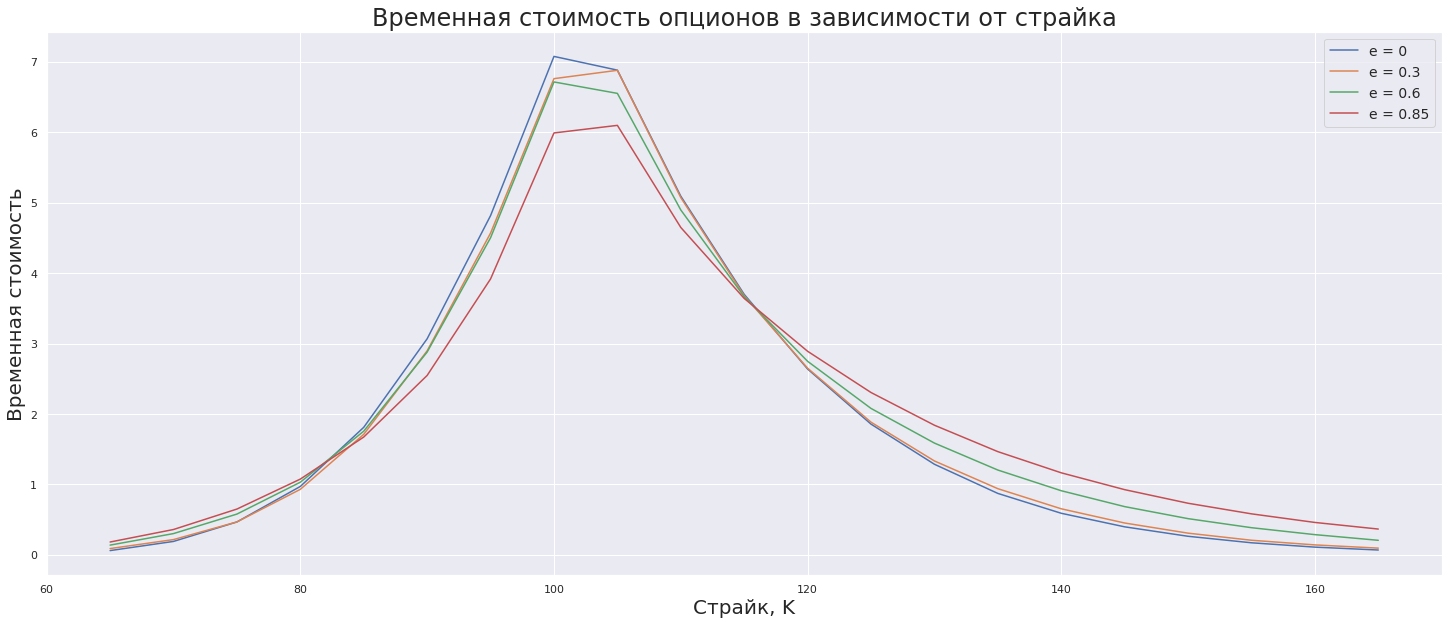

In [ ]:
spot = 100
sigma = 0.20
n = 10000
# страйки
ks = np.linspace(65, 165, 21)
eps = [0, 0.3, 0.6, 0.85]

# цены закрытия
pxs = {}
op_pxs = {}
for e in eps:
    # инициализируем класс распределения
    dist = cust_dist(e=e)
    # получаем выборку
    rets = sigma * dist.rvs(size=n)
    px = spot * np.exp(rets)
    pxs[e] = px
    # рассчитываем цену опциона
    op_px = [np.mean([max(x - k, 0) if k > spot else max(k - x, 0) for x in px]) for k in ks]
    op_pxs[e] = op_px

# отрисовка
fig, ax = plt.subplots(figsize=(25,10))

for e, op_px in op_pxs.items():
    ax.plot(ks, op_px, label="e = {}".format(e))

ax.set_title("Временная стоимость опционов в зависимости от страйка", fontsize=24)
ax.set_xlabel("Страйк, K", fontsize=20)
ax.set_ylabel("Временная стоимость", fontsize=20)
ax.legend(fontsize=14)

Получили график, показывающий, как изменяется временная стоимость опционов в зависимости от того, как мы меняем распределение относительно нормального, утолщая хвосты. Синяя линия показывает положение дел при нормальном распределении приращений (e=0). По мере увеличения e и как результат этого - утолщения хвостов, мы видим, что произошли две вещи:
*    как и ожидалось, временная стоимость опционов опционов на страйках далеко от начальной цены 100 *увеличилась*
*    временая стоимость опционов со страйком вокруг начальной цены 100 фактически *уменьшилась*.

То есть можно считать, что есть некоторый диапазон опционных страйков, где невыгодна возросшая вероятность значительных ценовых движений. Почему? Потому что вероятность "средних" ценовых движений при этом уменьшается - распределение "сужается в плечах".

Может показаться, что именения временной стоимости довольно невелики, но попробуем отрисовать график процентной разницы во временной стоимости между толстохвостым распределением и нормальным.

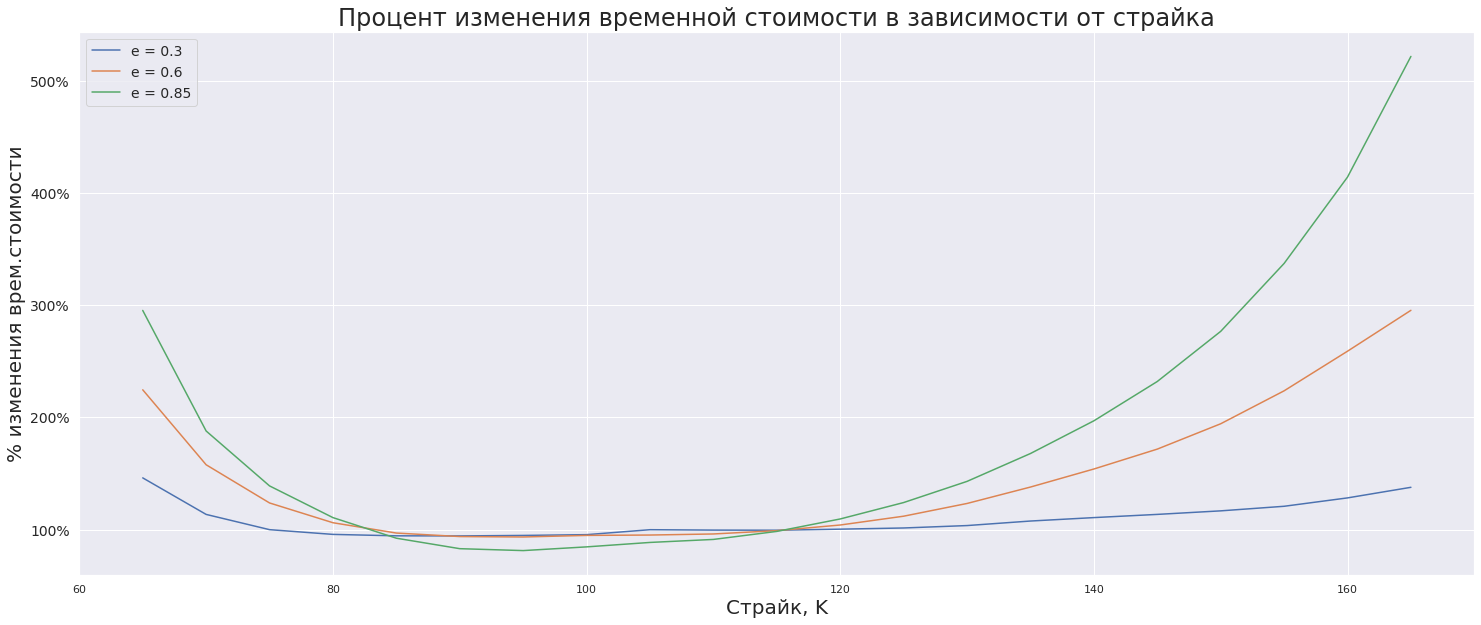

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))

for e, op_px in op_pxs.items():
    if e != 0:
        ax.plot(ks, [x/y for x,y in zip(op_px, op_pxs[0])], label="e = {}".format(e))

ax.set_title("Процент изменения временной стоимости в зависимости от страйка", fontsize=24)
ax.set_xlabel("Страйк, K", fontsize=20)
ax.set_ylabel("% изменения врем.стоимости", fontsize=20)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()], fontsize=14)
ax.legend(fontsize=14);

## Заключение
В подобном разрезе мы видим, что "крайние опционы" - опционы со страйками, далекими от текущей цены спота (более точно будет сказать - форварда) - получают наибольшую выгоду от утолщения хвостов. В действительности именно это имеется в виду, когда говорят, что опционы отражают выпуклость, истинную нелинейность. Именно опционами на GME торговала банда WallStreetBets, теми самыми, которые дали огромную прибыль при "реализации хвоста", за счет той самой нелинейности, которой посвящены фильмы типа "Игры на понижение".